In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
data_2017 = pd.read_excel("Data\\1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx", sheet_name="2017")
data_2018 = pd.read_excel("Data\\1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx", sheet_name="2018")
data_2019 = pd.read_excel("Data\\1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx", sheet_name="2019")
data_2020 = pd.read_excel("Data\\1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx", sheet_name="2020")
data_2021 = pd.read_excel("Data\\1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx", sheet_name="2021")
data_2017 = data_2017.iloc[1:]
data_2018 = data_2018.iloc[1:]
data_2019 = data_2019.iloc[1:]
data_2020 = data_2020.iloc[1:]
data_2021 = data_2021.iloc[1:]

In [5]:
x_1 = data_2017['в кубах ,м3']
x_2 = data_2018['Unnamed: 0']
x_3 = data_2019['Unnamed: 0']
x_4 = data_2020[:366]['Unnamed: 0']
x = pd.concat([x_1,x_2,x_3,x_4])

In [6]:
y_1 = data_2017['Unnamed: 1']
y_2 = data_2018['хранение факт']
y_3 = data_2019['хранение факт']
y_4 = data_2020[:366]['хранение факт']
y = pd.concat([y_1,y_2,y_3,y_4])

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [8]:
TRAIN_SPLIT = 1000

In [9]:
data = y
data.index = x

In [10]:
data = data.values

In [11]:
train_data = data[:TRAIN_SPLIT]
test_data = data[TRAIN_SPLIT:]

In [12]:
data_min = train_data.min()
data_max = train_data.max()

In [13]:
def normalize(x):
    return (x-data_min)/data_max

In [14]:
def invert_normalize(x):
    return x*data_max + data_min

In [15]:
data = normalize(data)

In [136]:
past_history = 150
future_target = 30

In [137]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [138]:
data

array([0.030749575682524195, 0.030749575682524195, 0.030749575682524195,
       ..., 0.8118760559052576, 0.7991169623649852, 0.7955914233604362],
      dtype=object)

In [139]:
x_train_uni, y_train_uni = univariate_data(data, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
x_val_uni, y_val_uni = univariate_data(data, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

In [140]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[0.030749575682524195]
 [0.030749575682524195]
 [0.030749575682524195]
 [0.030749575682524195]
 [0.030749575682524195]
 [0.030749575682524195]
 [0.030749575682524195]
 [0.030749575682524195]
 [0.030749575682524195]
 [0.0333698905769528]
 [0.03379161219502079]
 [0.032928023021716]
 [0.03451283674566565]
 [0.03451283674566565]
 [0.03451283674566565]
 [0.0316561428551225]
 [0.037639486194271314]
 [0.03776036181728437]
 [0.04171836693972482]
 [0.03809881356172113]
 [0.03809881356172113]
 [0.03809881356172113]
 [0.05148108809175004]
 [0.04722895228664454]
 [0.04699794554044168]
 [0.06714119658433693]
 [0.06443089650388757]
 [0.06443089650388757]
 [0.06443089650388757]
 [0.07079701264924448]
 [0.06817535469233806]
 [0.06971450429203817]
 [0.07207963731566137]
 [0.06786242113498178]
 [0.06786242113498178]
 [0.06786242113498178]
 [0.06419854669520676]
 [0.06267148465780774]
 [0.053098135315169694]
 [0.052008911645573856]
 [0.04828325633181422]
 [0.048283256331814

In [141]:
BATCH_SIZE = 200
BUFFER_SIZE = 10000

x_train_uni = np.asarray(x_train_uni).astype('float32')
y_train_uni = np.asarray(y_train_uni).astype('float32')
x_val_uni = np.asarray(x_val_uni).astype('float32')
y_val_uni = np.asarray(y_val_uni).astype('float32')

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [142]:
def create_time_steps(length):
    return list(range(-length, 0))

In [143]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'd:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

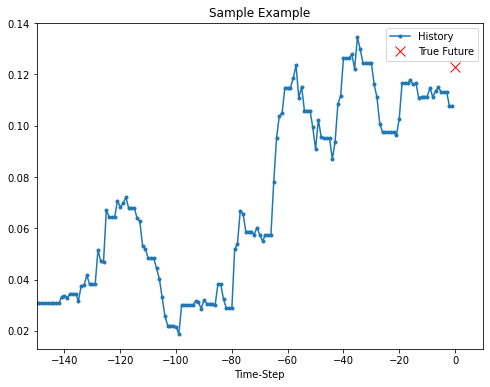

In [144]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [145]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(30)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [146]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

7/7 [==============================] - 1s 18ms/step
(200, 30)


In [147]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 24s 101ms/step - loss: 0.0634 - val_loss: 0.0831
Epoch 2/10
200/200 [==============================] - 15s 75ms/step - loss: 0.0466 - val_loss: 0.0833
Epoch 3/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0447 - val_loss: 0.0965
Epoch 4/10
200/200 [==============================] - 15s 73ms/step - loss: 0.0441 - val_loss: 0.0954
Epoch 5/10
200/200 [==============================] - 15s 73ms/step - loss: 0.0435 - val_loss: 0.1059
Epoch 6/10
200/200 [==============================] - 15s 73ms/step - loss: 0.0434 - val_loss: 0.1118
Epoch 7/10
200/200 [==============================] - 15s 73ms/step - loss: 0.0426 - val_loss: 0.1125
Epoch 8/10
200/200 [==============================] - 15s 73ms/step - loss: 0.0420 - val_loss: 0.1314
Epoch 9/10
200/200 [==============================] - 15s 73ms/step - loss: 0.0407 - val_loss: 0.0773
Epoch 10/10
200/200 [==============================] - 15s 76ms/step - loss: 0.03

In [149]:
simple_lstm_model.predict(x)[0]

7/7 [==============================] - 0s 21ms/step


array([0.14263976, 0.14831679, 0.14785297, 0.14208317, 0.14705154,
       0.14482018, 0.14359704, 0.14651687, 0.15028673, 0.146955  ,
       0.14520898, 0.14653894, 0.14634462, 0.14283581, 0.14481309,
       0.1438478 , 0.14591548, 0.14640088, 0.1452828 , 0.1404464 ,
       0.14726098, 0.14592491, 0.14656727, 0.14762092, 0.14726622,
       0.14692019, 0.14452687, 0.14463522, 0.14540471, 0.14225918],
      dtype=float32)

In [153]:
y[0].numpy()

0.07454281

7/7 [==============================] - 0s 24ms/step


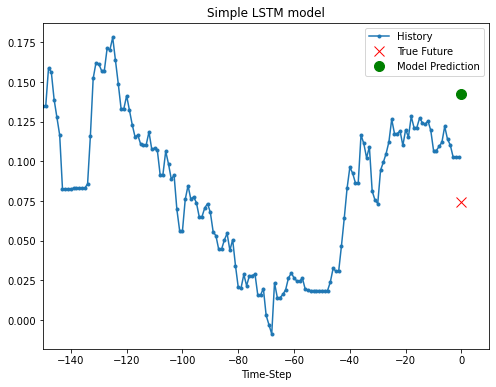

3/3 [==============================] - 0s 21ms/step


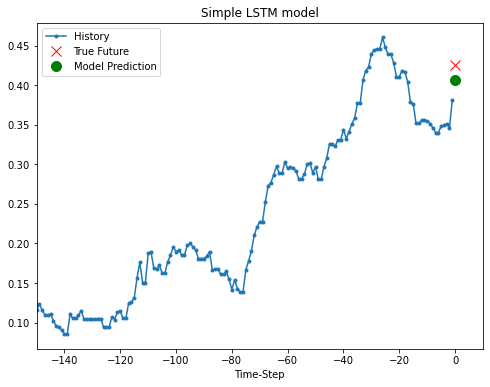

In [159]:
for x, y in val_univariate.take(2):
  # print(x[0].numpy())
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0][0]], 0, 'Simple LSTM model')
  plot.show()